In [75]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import random as rd

df_all = pd.read_csv("kc_house_data.csv")
df = df_all.sample(n=100, random_state=1)

df.head()
df.columns



Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Linear function:  
245.5 x + 1.267e+04


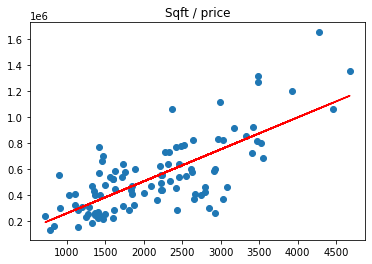

In [76]:
plt.scatter(df['sqft_living'], df["price"])
z = np.polyfit(df['sqft_living'], df["price"], 1)
p = np.poly1d(z)
print(f"Linear function: {p}")
trend_h = p(df['sqft_living'])
plt.plot(df['sqft_living'],trend_h, "r-")
plt.title("Sqft / price")
plt.show()

In [77]:


print(len(df_small['sqft_living']))

100


In [78]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living']}
model_1_prior = CmdStanModel(stan_file='stan_1_ppc.stan')
model_1_prior_simulated = model_1_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [79]:
model_1_prior_simulated.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.00,0.0,0.0,NaN,NaN,NaN
alpha,44000.0,77.000,2500.0,40000.00,44000.0,48000.0,1100.0,13000.0,1.0
beta,280.0,4.500,150.0,12.00,280.0,530.0,1200.0,14000.0,1.0
sigma,2.0,0.055,1.9,0.12,1.4,5.9,1200.0,14000.0,1.0
price[1],814061.0,12623.000,428896.0,78718.00,823729.0,1520490.0,1154.0,13909.0,1.0
...,...,...,...,...,...,...,...,...,...
price[96],400031.0,5838.000,198338.0,60020.00,405630.0,727602.0,1154.0,13906.0,1.0
price[97],662250.0,10135.000,344357.0,71860.00,671005.0,1229770.0,1154.0,13908.0,1.0
price[98],852703.0,13257.000,450416.0,80461.00,862714.0,1594500.0,1154.0,13909.0,1.0


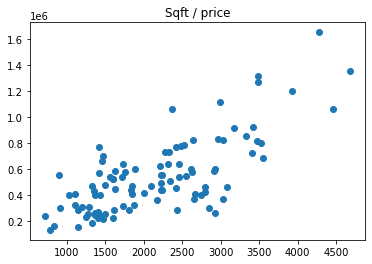

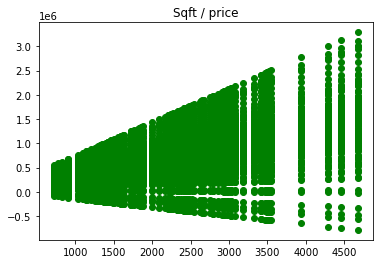

In [80]:
prices_sim=model_1_prior_simulated.stan_variable('price')
plt.scatter(df['sqft_living'], df["price"])
plt.title("Sqft / price")
plt.show()

prices_sim=model_1_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.scatter(df['sqft_living'], prices_sim[i], color="g")

plt.title("Sqft / price")
plt.show()

In [81]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living']}
model_2_prior = CmdStanModel(stan_file='stan_2_ppc.stan')
model_2_prior_simulated = model_2_prior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=True, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


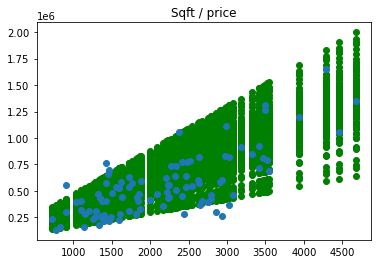

In [82]:
prices_sim=model_2_prior_simulated.stan_variable('price')

for i in range(0,len(df['sqft_living'])):
    plt.scatter(df['sqft_living'], prices_sim[i], color="g")

plt.scatter(df['sqft_living'], df["price"])

plt.title("Sqft / price")
plt.show()

In [83]:
stan_1_posterior

NameError: name 'stan_1_posterior' is not defined

In [87]:
data = {'N': len(df['sqft_living']),
        'sqft': df['sqft_living'],
        'price': df['price']}
model_1_posterior = CmdStanModel(stan_file='stan_1_posterior.stan')
model_1_prior_simulated = model_1_posterior.sample(data=data, iter_sampling=1000, iter_warmup=0, chains=1, refresh=1000, fixed_param=False, seed=21370204)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 StatusERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


RuntimeError: Error during sampling:
Command and output files:
RunSet: chains=1, chain_ids=[1], num_processes=1
 cmd (chain 1):
	['/home/nicolas/Projects/DA_project/stan_1_posterior', 'id=1', 'random', 'seed=21370204', 'data', 'file=/tmp/tmp148xck9m/sf8yaz9o.json', 'output', 'file=/tmp/tmp148xck9m/stan_1_posterior-20220612160207.csv', 'refresh=1000', 'method=sample', 'num_samples=1000', 'num_warmup=0', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp148xck9m/stan_1_posterior-20220612160207.csv
 console_msgs (if any):
	/tmp/tmp148xck9m/stan_1_posterior-20220612160207_0-stdout.txt